# **Model Evaluation**

**Course:** Master in Big Data, Data Science & AI — Master Thesis  
**Author:** Carlota Trigo La Blanca  

*This notebook will be used to evaluate and compare the trained models.*

## **Initialization**

In [1]:
# Import utils and additional required libraries
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import utils

from sklearn.metrics import (
    f1_score, balanced_accuracy_score, matthews_corrcoef,
    precision_score, recall_score, precision_recall_curve,
    average_precision_score, roc_auc_score, roc_curve,
    confusion_matrix, classification_report,
)
from sklearn.calibration import calibration_curve

# Theme & style (Viridis + compact fonts)
sns.set_theme(style="whitegrid")
sns.set_palette("viridis")
plt.rcParams.update({
    "image.cmap": "viridis",
    "axes.titlesize": 10,
    "figure.titlesize": 10,
    "axes.labelsize": 9,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "legend.fontsize": 8,
    "legend.title_fontsize": 9,
})

# Use constants from utils
IMG_SIZE = utils.IMG_SIZE
BATCH_SIZE = utils.BATCH_SIZE
DX_CLASSES = utils.DX_CLASSES
LESION_TYPE_CLASSES = utils.LESION_TYPE_CLASSES
N_DX_CLASSES = utils.N_DX_CLASSES
N_LESION_TYPE_CLASSES = utils.N_LESION_TYPE_CLASSES

def calculate_general_evaluation_metrics(y_true, y_pred, y_proba, class_names):
    """
    Calculate general evaluation metrics as specified in the requirements.
    
    Args:
        y_true: True labels
        y_pred: Predicted labels
        y_proba: Predicted probabilities
        class_names: List of class names
    
    Returns:
        dict: Dictionary containing all general evaluation metrics
    """
    metrics = {}
    
    # 1. Macro F1 (primary summary metric)
    metrics['macro_f1'] = f1_score(y_true, y_pred, average='macro')
    
    # 2. Balanced accuracy (average of per-class recall)
    metrics['balanced_accuracy'] = balanced_accuracy_score(y_true, y_pred)
    
    # 3. Matthews Correlation Coefficient (MCC)
    metrics['mcc'] = matthews_corrcoef(y_true, y_pred)
    
    # 4. Per-class precision, recall, and F1
    precision_per_class = precision_score(y_true, y_pred, average=None, zero_division='warn')
    recall_per_class = recall_score(y_true, y_pred, average=None, zero_division='warn')
    f1_per_class = f1_score(y_true, y_pred, average=None, zero_division='warn')
    
    metrics['per_class_precision'] = {class_names[i]: precision_per_class[i] for i in range(len(class_names))}
    metrics['per_class_recall'] = {class_names[i]: recall_per_class[i] for i in range(len(class_names))}
    metrics['per_class_f1'] = {class_names[i]: f1_per_class[i] for i in range(len(class_names))}
    
    # 5. Per-class Precision-Recall curves and AUPRC
    auprc_per_class = {}
    for i, class_name in enumerate(class_names):
        # Binary labels for this class
        y_true_binary = (y_true == i).astype(int)
        y_proba_binary = y_proba[:, i]
        
        # Calculate AUPRC
        if len(np.unique(y_true_binary)) > 1:  # Check if class exists in test set
            auprc = average_precision_score(y_true_binary, y_proba_binary)
            auprc_per_class[class_name] = auprc
        else:
            auprc_per_class[class_name] = 0.0
    
    metrics['per_class_auprc'] = auprc_per_class
    metrics['macro_auprc'] = np.mean(list(auprc_per_class.values()))
    
    # 6. Expected Calibration Error (ECE)
    metrics['ece'] = calculate_ece(y_true, y_pred, y_proba, n_bins=10)
    
    return metrics

def calculate_ece(y_true, y_pred, y_proba, n_bins=10):
    """
    Calculate Expected Calibration Error (ECE).
    
    Args:
        y_true: True labels
        y_pred: Predicted labels
        y_proba: Predicted probabilities
        n_bins: Number of bins for calibration
    
    Returns:
        float: Expected Calibration Error
    """
    # Get confidence scores (max probability)
    confidences = np.max(y_proba, axis=1)
    
    # Create bins
    bin_boundaries = np.linspace(0, 1, n_bins + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]
    
    ece = 0
    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        # Find samples in this bin
        in_bin = (confidences > bin_lower) & (confidences <= bin_upper)
        prop_in_bin = in_bin.mean()
        
        if prop_in_bin > 0:
            # Calculate accuracy and confidence in this bin
            accuracy_in_bin = (y_pred[in_bin] == y_true[in_bin]).mean()
            avg_confidence_in_bin = confidences[in_bin].mean()
            
            # Add to ECE
            ece += np.abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin
    
    return ece

def calculate_two_head_metrics(y_true_h1, y_pred_h1, y_true_h2, y_pred_h2):
    """
    Calculate two-head architecture evaluation metrics.
    
    Args:
        y_true_h1: True labels for head 1 (fine-grained)
        y_pred_h1: Predicted labels for head 1
        y_true_h2: True labels for head 2 (coarse)
        y_pred_h2: Predicted labels for head 2
    
    Returns:
        dict: Dictionary containing two-head metrics
    """
    metrics = {}
    
    # Filter valid samples (where fine-grained labels are available)
    valid_mask = y_true_h1 >= 0
    valid_y_true_h1 = y_true_h1[valid_mask]
    valid_y_pred_h1 = y_pred_h1[valid_mask]
    valid_y_true_h2 = y_true_h2[valid_mask]
    valid_y_pred_h2 = y_pred_h2[valid_mask]
    
    # 1. Exact-match: Both heads correct
    exact_match = (valid_y_pred_h1 == valid_y_true_h1) & (valid_y_pred_h2 == valid_y_true_h2)
    metrics['exact_match'] = exact_match.mean()
    
    # 2. Coarse-correct: Balanced accuracy for head 2 (lesion type)
    metrics['coarse_correct'] = balanced_accuracy_score(valid_y_true_h2, valid_y_pred_h2)
    
    # 3. Fine-conditional: Macro-F1 of head 1, only when head 2 is correct
    coarse_correct_mask = valid_y_pred_h2 == valid_y_true_h2
    if coarse_correct_mask.sum() > 0:
        fine_conditional_f1 = f1_score(
            valid_y_true_h1[coarse_correct_mask], 
            valid_y_pred_h1[coarse_correct_mask], 
            average='macro'
        )
    else:
        fine_conditional_f1 = 0.0
    
    metrics['fine_conditional'] = fine_conditional_f1
    
    return metrics

def calculate_ood_metrics(id_logits, ood_logits, n_bins=100):
    """
    Calculate out-of-distribution detection metrics.
    
    Args:
        id_logits: In-distribution logits
        ood_logits: Out-of-distribution logits
        n_bins: Number of bins for AUPRC calculation
    
    Returns:
        dict: Dictionary containing OOD detection metrics
    """
    # Calculate MSP scores
    id_msp = np.max(tf.nn.softmax(id_logits, axis=1).numpy(), axis=1)
    ood_msp = np.max(tf.nn.softmax(ood_logits, axis=1).numpy(), axis=1)
    
    # Create binary labels (1 for ID, 0 for OOD)
    id_labels = np.ones_like(id_msp)
    ood_labels = np.zeros_like(ood_msp)
    
    all_scores = np.concatenate([id_msp, ood_msp])
    all_labels = np.concatenate([id_labels, ood_labels])
    
    # 1. AUROC
    auroc = roc_auc_score(all_labels, all_scores)
    
    # 2. AUPRC
    auprc = average_precision_score(all_labels, all_scores)
    
    # 3. FPR@95%TPR
    from sklearn.metrics import roc_curve
    fpr, tpr, thresholds = roc_curve(all_labels, all_scores)
    
    # Find threshold where TPR = 0.95
    tpr_95_idx = np.where(tpr >= 0.95)[0]
    if len(tpr_95_idx) > 0:
        fpr_95 = fpr[tpr_95_idx[0]]
    else:
        fpr_95 = 1.0
    
    # 4. Detection error (minimum of FNR + FPR)
    fnr = 1 - tpr  # False Negative Rate
    detection_error = np.min(fnr + fpr)
    
    return {
        'auroc': auroc,
        'auprc': auprc,
        'fpr_at_95_tpr': fpr_95,
        'detection_error': detection_error,
        'id_msp_mean': np.mean(id_msp),
        'ood_msp_mean': np.mean(ood_msp)
    }

# Use functions from utils instead of defining them locally
def build_augmenter(is_training):
    if is_training:
        raise ValueError("build_augmenter should not be called with is_training=True during evaluation.")
    return utils.build_augmenter(is_training, augmentation_strength='medium')

def build_dataset(df, is_training=False):
    if is_training:
        raise ValueError("build_dataset should not be called with is_training=True during evaluation.")
    return utils.build_dataset(df, is_training=is_training)

def masked_sparse_categorical_crossentropy(y_true, y_pred):
    return utils.masked_sparse_categorical_crossentropy(y_true, y_pred)

def create_two_head_model(n_fine, n_coarse, img_size=IMG_SIZE, dropout=0.2):
    """Creates the two-headed model using the Keras Functional API."""
    return utils.create_two_head_model('efficientnet', n_fine, n_coarse, img_size, dropout)

def load_individual_model(model_path):
    """Load individual model from path."""
    return utils.load_individual_model(model_path, 'efficientnet')

def load_ensemble_models():
    """Load individual models for ensemble."""
    return utils.load_ensemble_models(INDIVIDUAL_DIR)

# Create ensemble predictions using utils functions
def create_voting_ensemble(models_dict, dataset):
    """Create voting ensemble from multiple models."""
    return utils.create_voting_ensemble(models_dict, dataset)

def create_weighted_ensemble(models_dict, dataset, weights=None):
    """Create weighted ensemble from multiple models."""
    return utils.create_weighted_ensemble(models_dict, dataset, weights)

In [2]:
# Use constants from utils
from pathlib import Path
SEED = utils.SEED
DATA_DIR = utils.DATA_DIR
PREPARED_CSV = utils.PREPARED_CSV
IMAGE_PATH = utils.IMAGE_PATH

# Model paths
BASELINE_DIR = Path("./outputs/base_model")
SSL_DIR = Path("./outputs/ssl_finetuned")
ENSEMBLE_DIR = Path("./outputs/ensemble_models")
INDIVIDUAL_DIR = Path("./outputs/individual_models")

# Model configurations
MODELS_CONFIG = {
    'baseline': {
        'name': 'Baseline EfficientNetB1',
        'path': BASELINE_DIR / "simple_twohead_best_model.keras",
        'type': 'single',
        'color': '#440154'  
    },
    'ssl': {
        'name': 'SSL Fine-tuned',
        'path': SSL_DIR / "ssl_finetuned_best_model.keras", 
        'type': 'single',
        'color': '#31688e'  
    },
    'resnet': {
        'name': 'ResNet50',
        'path': INDIVIDUAL_DIR / "resnet" / "resnet_best_model.keras",
        'type': 'individual',
        'color': '#35b779' 
    },
    'densenet': {
        'name': 'DenseNet121',
        'path': INDIVIDUAL_DIR / "densenet" / "densenet_best_model.keras", 
        'type': 'individual',
        'color': '#6ece58'  
    },
    'ensemble_voting': {
        'name': 'Voting Ensemble',
        'path': ENSEMBLE_DIR / "stacking_best_model.keras",
        'type': 'ensemble',
        'color': '#fde725'  
    }
}

In [3]:
# Load test data and get predictions using utils
df = pd.read_csv(PREPARED_CSV)
test_df = df[df.split == "test"].copy()
ood_df = df[df.split == "test_ood"].copy()

print(f"Test samples: {len(test_df)}")
print(f"OOD samples: {len(ood_df)}")

test_ds = utils.build_dataset(test_df, is_training=False)
ood_ds = utils.build_dataset(ood_df, is_training=False)

def get_predictions_and_labels(model, dataset):
    """Get predictions and labels from a model."""
    return utils.get_predictions_and_labels(model, dataset)

def get_ensemble_predictions(ensemble_models, dataset, method='voting'):
    """Get ensemble predictions."""
    return utils.get_ensemble_predictions(ensemble_models, dataset, method)

Test samples: 10359
OOD samples: 2669


In [4]:
# Load models
models = {}
ensemble_models = {}

# Load individual models
for model_key, config in MODELS_CONFIG.items():
    if config['type'] == 'single':
        model = utils.load_individual_model(config['path'], 'efficientnet')
        if model is not None:
            models[model_key] = model

# Load ensemble models
ensemble_models = utils.load_ensemble_models(INDIVIDUAL_DIR)

✓ Loaded complete model from outputs\base_model\simple_twohead_best_model.keras
✓ Loaded complete model from outputs\ssl_finetuned\ssl_finetuned_best_model.keras
✓ Loaded complete model from outputs\individual_models\efficientnet\efficientnet_best_model.keras
✓ Loaded complete model from outputs\individual_models\resnet\resnet_best_model.keras
✓ Loaded complete model from outputs\individual_models\densenet\densenet_best_model.keras


In [5]:
# Get predictions for BASELINE AND SSL
all_predictions = {}

# Individual models
for model_key, model in models.items():
    print(f"\nEvaluating {MODELS_CONFIG[model_key]['name']}...")
    id_labels_h1, id_logits_h1, id_labels_h2, id_logits_h2 = utils.get_predictions_and_labels(model, test_ds)
    ood_labels_h1, ood_logits_h1, ood_labels_h2, ood_logits_h2 = utils.get_predictions_and_labels(model, ood_ds)
    
    all_predictions[model_key] = {
        'id_labels_h1': id_labels_h1, 'id_logits_h1': id_logits_h1,
        'id_labels_h2': id_labels_h2, 'id_logits_h2': id_logits_h2,
        'ood_labels_h1': ood_labels_h1, 'ood_logits_h1': ood_logits_h1,
        'ood_labels_h2': ood_labels_h2, 'ood_logits_h2': ood_logits_h2
    }


Evaluating Baseline EfficientNetB1...

Evaluating SSL Fine-tuned...


In [6]:
# Get predictions for ResNet AND DenseNet
for model_key in ['resnet', 'densenet']:
    model = ensemble_models[model_key]
    print(f"Evaluating {model_key} individually...")
    id_labels_h1, id_logits_h1, id_labels_h2, id_logits_h2 = utils.get_predictions_and_labels(model, test_ds)
    ood_labels_h1, ood_logits_h1, ood_labels_h2, ood_logits_h2 = utils.get_predictions_and_labels(model, ood_ds)
    
    all_predictions[model_key] = {
        'id_labels_h1': id_labels_h1, 'id_logits_h1': id_logits_h1,
        'id_labels_h2': id_labels_h2, 'id_logits_h2': id_logits_h2,
        'ood_labels_h1': ood_labels_h1, 'ood_logits_h1': ood_logits_h1,
        'ood_labels_h2': ood_labels_h2, 'ood_logits_h2': ood_logits_h2
    }

Evaluating resnet individually...
Evaluating densenet individually...


In [7]:
# # Get predictions for ENSEMBLE models
if len(ensemble_models) > 0:
    print(f"\nEvaluating ensemble models...")
    
    # Voting ensemble
    id_labels_h1, id_logits_h1, id_labels_h2, id_logits_h2 = utils.get_ensemble_predictions(ensemble_models, test_ds, 'voting')
    ood_labels_h1, ood_logits_h1, ood_labels_h2, ood_logits_h2 = utils.get_ensemble_predictions(ensemble_models, ood_ds, 'voting')
    
    all_predictions['ensemble_voting'] = {
        'id_labels_h1': id_labels_h1, 'id_logits_h1': id_logits_h1,
        'id_labels_h2': id_labels_h2, 'id_logits_h2': id_logits_h2,
        'ood_labels_h1': ood_labels_h1, 'ood_logits_h1': ood_logits_h1,
        'ood_labels_h2': ood_labels_h2, 'ood_logits_h2': ood_logits_h2
    }


Evaluating ensemble models...


In [8]:
import pickle
with open("outputs/all_predictions.pkl", "wb") as f:
    pickle.dump(all_predictions, f, protocol=pickle.HIGHEST_PROTOCOL)

In [9]:
import pickle
with open("outputs/all_predictions.pkl", "rb") as f:
    all_predictions = pickle.load(f)

## Model Evaluation

In [10]:
# Use utils functions for evaluation
def plot_confusion_matrix(labels, preds, class_names, title):
    """Plot confusion matrix."""
    return utils.plot_confusion_matrix(labels, preds, class_names, title)

def calculate_metrics(labels, preds, class_names):
    """Calculate comprehensive metrics."""
    return utils.calculate_metrics(labels, preds, class_names)

def print_metrics(fine_general_metrics, coarse_general_metrics, two_head_metrics, ood_metrics):
    """Print all evaluation metrics."""
    print(f"Fine-grained (Diagnosis) Metrics:")
    print(f"  Macro F1: {fine_general_metrics['macro_f1']:.4f}")
    print(f"  Balanced Accuracy: {fine_general_metrics['balanced_accuracy']:.4f}")
    print(f"  Matthews Correlation Coefficient: {fine_general_metrics['mcc']:.4f}")
    print(f"  Macro AUPRC: {fine_general_metrics['macro_auprc']:.4f}")
    print(f"  Expected Calibration Error: {fine_general_metrics['ece']:.4f}")
    
    print(f"\nCoarse (Lesion Type) Metrics:")
    print(f"  Macro F1: {coarse_general_metrics['macro_f1']:.4f}")
    print(f"  Balanced Accuracy: {coarse_general_metrics['balanced_accuracy']:.4f}")
    print(f"  Matthews Correlation Coefficient: {coarse_general_metrics['mcc']:.4f}")
    print(f"  Macro AUPRC: {coarse_general_metrics['macro_auprc']:.4f}")
    print(f"  Expected Calibration Error: {coarse_general_metrics['ece']:.4f}")
    
    
    print(f"\nTwo-head Architecture Metrics:")
    print(f"  Exact-match (Both heads correct): {two_head_metrics['exact_match']:.4f}")
    print(f"  Coarse-correct (Balanced accuracy for lesion type): {two_head_metrics['coarse_correct']:.4f}")
    print(f"  Fine-conditional (Macro-F1 of diagnosis when lesion type correct): {two_head_metrics['fine_conditional']:.4f}")

    print(f"\nOut-of-Distribution Detection Metrics:")
    print(f"  AUROC: {ood_metrics['auroc']:.4f}")
    print(f"  AUPRC: {ood_metrics['auprc']:.4f}")
    print(f"  FPR@95%TPR: {ood_metrics['fpr_at_95_tpr']:.4f}")
    print(f"  Detection Error: {ood_metrics['detection_error']:.4f}")
    print(f"  ID MSP Mean: {ood_metrics['id_msp_mean']:.4f}")
    print(f"  OOD MSP Mean: {ood_metrics['ood_msp_mean']:.4f}")

    # Per-class metrics for coarse classification
    if 'per_class_precision' in coarse_general_metrics:
        print(f"\nPer-class Coarse Metrics:")
        coarse_df = pd.DataFrame({
            'Class': list(coarse_general_metrics['per_class_precision'].keys()),
            'Precision': list(coarse_general_metrics['per_class_precision'].values()),
            'Recall': list(coarse_general_metrics['per_class_recall'].values()),
            'F1': list(coarse_general_metrics['per_class_f1'].values()),
            'AUPRC': list(coarse_general_metrics['per_class_auprc'].values())
        })
        print(coarse_df.round(4).to_string(index=False))

    if 'per_class_precision' in fine_general_metrics:
        print(f"\nPer-class Fine-grained Metrics:")
        fine_df = pd.DataFrame({
            'Class': list(fine_general_metrics['per_class_precision'].keys()),
            'Precision': list(fine_general_metrics['per_class_precision'].values()),
            'Recall': list(fine_general_metrics['per_class_recall'].values()),
            'F1': list(fine_general_metrics['per_class_f1'].values()),
            'AUPRC': list(fine_general_metrics['per_class_auprc'].values())
        })
        print(fine_df.round(4).to_string(index=False))
    return

def get_id_preds_proba(predictions):
    """Get predicted classes and probabilities for ID samples."""
    id_preds_h1 = np.argmax(predictions['id_logits_h1'], axis=1)
    id_preds_h2 = np.argmax(predictions['id_logits_h2'], axis=1)
    id_proba_h1 = tf.nn.softmax(predictions['id_logits_h1']).numpy()
    id_proba_h2 = tf.nn.softmax(predictions['id_logits_h2']).numpy()

    # Filter valid samples for fine-grained evaluation
    valid_mask_h2 = predictions['id_labels_h2'] >= 0
    valid_labels_h2 = predictions['id_labels_h2'][valid_mask_h2]
    valid_preds_h2 = id_preds_h2[valid_mask_h2]
    valid_proba_h2 = id_proba_h2[valid_mask_h2]

    return id_preds_h1, id_preds_h2, id_proba_h1, id_proba_h2, valid_labels_h2, valid_preds_h2, valid_proba_h2

all_results = {}

## Baseline (Efficientnet)

In [11]:
model_key = 'baseline'
predictions = all_predictions['baseline']
model_results = {}

id_preds_h1, id_preds_h2, id_proba_h1, id_proba_h2, valid_labels_h2, valid_preds_h2, valid_proba_h2 = get_id_preds_proba(predictions)

In [12]:
coarse_general_metrics = calculate_general_evaluation_metrics(
       predictions['id_labels_h1'], id_preds_h1, id_proba_h1, LESION_TYPE_CLASSES
   )
model_results['coarse_general'] = coarse_general_metrics

In [13]:
fine_general_metrics = calculate_general_evaluation_metrics(
                            valid_labels_h2, valid_preds_h2, valid_proba_h2, DX_CLASSES
                        )
model_results['fine_general'] = fine_general_metrics

In [14]:
two_head_metrics = calculate_two_head_metrics(
                        predictions['id_labels_h1'], id_preds_h1,
                        predictions['id_labels_h2'], id_preds_h2
                    )
model_results['two_head'] = two_head_metrics

In [15]:
ood_metrics = calculate_ood_metrics(
       predictions['id_logits_h2'], predictions['ood_logits_h2']
)
model_results['ood_detection'] = ood_metrics

In [16]:
print_metrics(fine_general_metrics, coarse_general_metrics, two_head_metrics, ood_metrics)
all_results[model_key] = model_results

Fine-grained (Diagnosis) Metrics:
  Macro F1: 0.0929
  Balanced Accuracy: 0.1583
  Matthews Correlation Coefficient: 0.2202
  Macro AUPRC: 0.1767
  Expected Calibration Error: 0.2305

Coarse (Lesion Type) Metrics:
  Macro F1: 0.2786
  Balanced Accuracy: 0.3333
  Matthews Correlation Coefficient: 0.0000
  Macro AUPRC: 0.3847
  Expected Calibration Error: 0.1920

Two-head Architecture Metrics:
  Exact-match (Both heads correct): 0.2030
  Coarse-correct (Balanced accuracy for lesion type): 0.1425
  Fine-conditional (Macro-F1 of diagnosis when lesion type correct): 0.4994

Out-of-Distribution Detection Metrics:
  AUROC: 0.5931
  AUPRC: 0.8490
  FPR@95%TPR: 0.9187
  Detection Error: 0.8612
  ID MSP Mean: 0.5097
  OOD MSP Mean: 0.4477

Per-class Coarse Metrics:
    Class  Precision  Recall     F1  AUPRC
   benign     0.7181     1.0 0.8359 0.7797
malignant     0.0000     0.0 0.0000 0.3439
no_lesion     0.0000     0.0 0.0000 0.0306

Per-class Fine-grained Metrics:
    Class  Precision  Recall 

## SSL 

In [17]:
model_key = 'ssl'
predictions = all_predictions['ssl']
model_results = {}

id_preds_h1, id_preds_h2, id_proba_h1, id_proba_h2, valid_labels_h2, valid_preds_h2, valid_proba_h2 = get_id_preds_proba(predictions)

In [18]:
coarse_general_metrics = calculate_general_evaluation_metrics(
       predictions['id_labels_h1'], id_preds_h1, id_proba_h1, LESION_TYPE_CLASSES
   )
model_results['coarse_general'] = coarse_general_metrics

In [19]:
fine_general_metrics = calculate_general_evaluation_metrics(
    valid_labels_h2, valid_preds_h2, valid_proba_h2, DX_CLASSES
)
model_results['fine_general'] = fine_general_metrics

In [20]:
two_head_metrics = calculate_two_head_metrics(
                        predictions['id_labels_h1'], id_preds_h1,
                        predictions['id_labels_h2'], id_preds_h2
                    )
model_results['two_head'] = two_head_metrics

In [21]:
ood_metrics = calculate_ood_metrics(
       predictions['id_logits_h2'], predictions['ood_logits_h2']
)
model_results['ood_detection'] = ood_metrics

In [22]:
print_metrics(fine_general_metrics, coarse_general_metrics, two_head_metrics, ood_metrics)
all_results[model_key] = model_results

Fine-grained (Diagnosis) Metrics:
  Macro F1: 0.1774
  Balanced Accuracy: 0.2565
  Matthews Correlation Coefficient: 0.2772
  Macro AUPRC: 0.3081
  Expected Calibration Error: 0.1290

Coarse (Lesion Type) Metrics:
  Macro F1: 0.4427
  Balanced Accuracy: 0.6641
  Matthews Correlation Coefficient: 0.2490
  Macro AUPRC: 0.6769
  Expected Calibration Error: 0.1046

Two-head Architecture Metrics:
  Exact-match (Both heads correct): 0.2419
  Coarse-correct (Balanced accuracy for lesion type): 0.2309
  Fine-conditional (Macro-F1 of diagnosis when lesion type correct): 0.5608

Out-of-Distribution Detection Metrics:
  AUROC: 0.5214
  AUPRC: 0.8012
  FPR@95%TPR: 0.9224
  Detection Error: 0.9448
  ID MSP Mean: 0.4814
  OOD MSP Mean: 0.4717

Per-class Coarse Metrics:
    Class  Precision  Recall     F1  AUPRC
   benign     0.8047  0.7942 0.7994 0.8642
malignant     0.5146  0.2058 0.2940 0.3790
no_lesion     0.1331  0.9924 0.2347 0.7873

Per-class Fine-grained Metrics:
    Class  Precision  Recall 

## Ensemble

### ResNet (Individually)

In [23]:
model_key = 'resnet'
predictions = all_predictions['resnet']
model_results = {}

id_preds_h1, id_preds_h2, id_proba_h1, id_proba_h2, valid_labels_h2, valid_preds_h2, valid_proba_h2 = get_id_preds_proba(predictions)

In [24]:
coarse_general_metrics = calculate_general_evaluation_metrics(
       predictions['id_labels_h1'], id_preds_h1, id_proba_h1, LESION_TYPE_CLASSES
   )
model_results['coarse_general'] = coarse_general_metrics

In [25]:
fine_general_metrics = calculate_general_evaluation_metrics(
    valid_labels_h2, valid_preds_h2, valid_proba_h2, DX_CLASSES
)
model_results['fine_general'] = fine_general_metrics

In [26]:
two_head_metrics = calculate_two_head_metrics(
                        predictions['id_labels_h1'], id_preds_h1,
                        predictions['id_labels_h2'], id_preds_h2
                    )
model_results['two_head'] = two_head_metrics

In [27]:
ood_metrics = calculate_ood_metrics(
       predictions['id_logits_h2'], predictions['ood_logits_h2']
)
model_results['ood_detection'] = ood_metrics

In [28]:
print_metrics(fine_general_metrics, coarse_general_metrics, two_head_metrics, ood_metrics)
all_results[model_key] = model_results

Fine-grained (Diagnosis) Metrics:
  Macro F1: 0.0910
  Balanced Accuracy: 0.1238
  Matthews Correlation Coefficient: 0.0864
  Macro AUPRC: 0.1896
  Expected Calibration Error: 0.4404

Coarse (Lesion Type) Metrics:
  Macro F1: 0.2792
  Balanced Accuracy: 0.3335
  Matthews Correlation Coefficient: 0.0153
  Macro AUPRC: 0.5030
  Expected Calibration Error: 0.1061

Two-head Architecture Metrics:
  Exact-match (Both heads correct): 0.2988
  Coarse-correct (Balanced accuracy for lesion type): 0.1115
  Fine-conditional (Macro-F1 of diagnosis when lesion type correct): 0.4999

Out-of-Distribution Detection Metrics:
  AUROC: 0.7129
  AUPRC: 0.9047
  FPR@95%TPR: 0.8782
  Detection Error: 0.6782
  ID MSP Mean: 0.8062
  OOD MSP Mean: 0.6316

Per-class Coarse Metrics:
    Class  Precision  Recall     F1  AUPRC
   benign     0.7183  0.9999 0.8360 0.8001
malignant     0.5000  0.0008 0.0015 0.4214
no_lesion     0.0000  0.0000 0.0000 0.2877

Per-class Fine-grained Metrics:
    Class  Precision  Recall 

### DenseNet (Individually)

In [29]:
model_key = 'densenet'
predictions = all_predictions['densenet']
model_results = {}

id_preds_h1, id_preds_h2, id_proba_h1, id_proba_h2, valid_labels_h2, valid_preds_h2, valid_proba_h2 = get_id_preds_proba(predictions)

In [30]:
coarse_general_metrics = calculate_general_evaluation_metrics(
       predictions['id_labels_h1'], id_preds_h1, id_proba_h1, LESION_TYPE_CLASSES
   )
model_results['coarse_general'] = coarse_general_metrics

In [31]:
fine_general_metrics = calculate_general_evaluation_metrics(
    valid_labels_h2, valid_preds_h2, valid_proba_h2, DX_CLASSES
)
model_results['fine_general'] = fine_general_metrics

In [32]:
two_head_metrics = calculate_two_head_metrics(
                        predictions['id_labels_h1'], id_preds_h1,
                        predictions['id_labels_h2'], id_preds_h2
                    )
model_results['two_head'] = two_head_metrics

In [33]:
ood_metrics = calculate_ood_metrics(
       predictions['id_logits_h2'], predictions['ood_logits_h2']
)
model_results['ood_detection'] = ood_metrics

In [34]:
print_metrics(fine_general_metrics, coarse_general_metrics, two_head_metrics, ood_metrics)
all_results[model_key] = model_results

Fine-grained (Diagnosis) Metrics:
  Macro F1: 0.1375
  Balanced Accuracy: 0.1903
  Matthews Correlation Coefficient: 0.1671
  Macro AUPRC: 0.1828
  Expected Calibration Error: 0.1174

Coarse (Lesion Type) Metrics:
  Macro F1: 0.2380
  Balanced Accuracy: 0.3833
  Matthews Correlation Coefficient: 0.0273
  Macro AUPRC: 0.4250
  Expected Calibration Error: 0.2413

Two-head Architecture Metrics:
  Exact-match (Both heads correct): 0.0406
  Coarse-correct (Balanced accuracy for lesion type): 0.1713
  Fine-conditional (Macro-F1 of diagnosis when lesion type correct): 0.1627

Out-of-Distribution Detection Metrics:
  AUROC: 0.5845
  AUPRC: 0.8515
  FPR@95%TPR: 0.9333
  Detection Error: 0.8672
  ID MSP Mean: 0.3696
  OOD MSP Mean: 0.3231

Per-class Coarse Metrics:
    Class  Precision  Recall     F1  AUPRC
   benign     0.7606  0.2464 0.3722 0.7501
malignant     0.2594  0.3044 0.2801 0.2956
no_lesion     0.0325  0.5992 0.0617 0.2294

Per-class Fine-grained Metrics:
    Class  Precision  Recall 

### Ensemble Voting

In [35]:
model_key = 'ensemble_voting'
predictions = all_predictions['ensemble_voting']
model_results = {}

id_preds_h1, id_preds_h2, id_proba_h1, id_proba_h2, valid_labels_h2, valid_preds_h2, valid_proba_h2 = get_id_preds_proba(predictions)

In [36]:
coarse_general_metrics = calculate_general_evaluation_metrics(
       predictions['id_labels_h1'], id_preds_h1, id_proba_h1, LESION_TYPE_CLASSES
   )
model_results['coarse_general'] = coarse_general_metrics

In [37]:
fine_general_metrics = calculate_general_evaluation_metrics(
    valid_labels_h2, valid_preds_h2, valid_proba_h2, DX_CLASSES
)
model_results['fine_general'] = fine_general_metrics

In [38]:
two_head_metrics = calculate_two_head_metrics(
                        predictions['id_labels_h1'], id_preds_h1,
                        predictions['id_labels_h2'], id_preds_h2
                    )
model_results['two_head'] = two_head_metrics

In [39]:
ood_metrics = calculate_ood_metrics(
       predictions['id_logits_h2'], predictions['ood_logits_h2']
)
model_results['ood_detection'] = ood_metrics

In [40]:
print_metrics(fine_general_metrics, coarse_general_metrics, two_head_metrics, ood_metrics)
all_results[model_key] = model_results

Fine-grained (Diagnosis) Metrics:
  Macro F1: 0.1260
  Balanced Accuracy: 0.1681
  Matthews Correlation Coefficient: 0.2243
  Macro AUPRC: 0.2283
  Expected Calibration Error: 0.0895

Coarse (Lesion Type) Metrics:
  Macro F1: 0.4077
  Balanced Accuracy: 0.4220
  Matthews Correlation Coefficient: 0.1789
  Macro AUPRC: 0.4883
  Expected Calibration Error: 0.0240

Two-head Architecture Metrics:
  Exact-match (Both heads correct): 0.3007
  Coarse-correct (Balanced accuracy for lesion type): 0.1513
  Fine-conditional (Macro-F1 of diagnosis when lesion type correct): 0.4306

Out-of-Distribution Detection Metrics:
  AUROC: 0.6901
  AUPRC: 0.8956
  FPR@95%TPR: 0.8700
  Detection Error: 0.7249
  ID MSP Mean: 0.4877
  OOD MSP Mean: 0.3450

Per-class Coarse Metrics:
    Class  Precision  Recall     F1  AUPRC
   benign     0.7351  0.9878 0.8429 0.8201
malignant     0.6845  0.0530 0.0985 0.4479
no_lesion     0.3758  0.2252 0.2816 0.1969

Per-class Fine-grained Metrics:
    Class  Precision  Recall 

# Figures

### Group results

In [ ]:
# --- helpers ---
SKIP = {'ensemble_weighted'}

def iter_models():
    """Yield (model_key, model_name, results) skipping unwanted keys."""
    for k, res in all_results.items():
        if k in SKIP:
            continue
        yield k, MODELS_CONFIG[k]['name'], res

def get(d, *path, default=float('nan')):
    """Safe nested get: get(d, 'a','b') -> d['a']['b'] or default."""
    for p in path:
        d = d.get(p, {})
    return d if d != {} else default

# Basic comparison table
basic_rows = []
for k, name, res in iter_models():
    fg, cg = res.get('fine_general', {}), res['coarse_general']
    basic_rows.append({
        'Model': name,
        'Fine Accuracy': fg.get('balanced_accuracy', float('nan')),
        'Fine F1': fg.get('macro_f1', float('nan')),
        'Fine MCC': fg.get('mcc', float('nan')),
        'Coarse Accuracy': cg['balanced_accuracy'],
        'Coarse F1': cg['macro_f1'],
        'Coarse MCC': cg['mcc'],
    })

comparison_df_basic = pd.DataFrame(basic_rows)
print("\nDetailed Comparison Table:")
print(comparison_df_basic.round(4))

# Best models from BASIC table (kept for downstream usage)
best_fine_acc     = comparison_df_basic.loc[comparison_df_basic['Fine Accuracy'].idxmax()]
best_fine_f1      = comparison_df_basic.loc[comparison_df_basic['Fine F1'].idxmax()]
best_coarse_acc   = comparison_df_basic.loc[comparison_df_basic['Coarse Accuracy'].idxmax()]
best_coarse_f1    = comparison_df_basic.loc[comparison_df_basic['Coarse F1'].idxmax()]

# Comprehensive comparison table
rows = []
for k, name, res in iter_models():
    row = {
        'Model': name,
        # Fine (general)
        'Fine Macro F1':        get(res, 'fine_general', 'macro_f1'),
        'Fine Balanced Acc':    get(res, 'fine_general', 'balanced_accuracy'),
        'Fine MCC':             get(res, 'fine_general', 'mcc'),
        'Fine Macro AUPRC':     get(res, 'fine_general', 'macro_auprc'),
        'Fine ECE':             get(res, 'fine_general', 'ece'),
        # Coarse (general)
        'Coarse Macro F1':      res['coarse_general']['macro_f1'],
        'Coarse Balanced Acc':  res['coarse_general']['balanced_accuracy'],
        'Coarse MCC':           res['coarse_general']['mcc'],
        'Coarse Macro AUPRC':   res['coarse_general']['macro_auprc'],
        'Coarse ECE':           res['coarse_general']['ece'],
        # Two-head
        'Exact Match':          res['two_head']['exact_match'],
        'Coarse Correct':       res['two_head']['coarse_correct'],
        'Fine Conditional':     res['two_head']['fine_conditional'],
        # OOD (from results dict; raw metrics)
        'OOD AUROC':            res['ood_detection']['auroc'],
        'OOD AUPRC':            res['ood_detection']['auprc'],
        'OOD FPR@95%TPR':       res['ood_detection']['fpr_at_95_tpr'],
        'OOD Detection Error':  res['ood_detection']['detection_error'],
    }
    rows.append(row)

# Final comprehensive DataFrame (same variable name as your script)
comparison_df = pd.DataFrame(rows)
print(comparison_df.round(4).to_string(index=False))

# Best models from COMPREHENSIVE table (same variable names as your script)
if 'Fine Macro F1' in comparison_df.columns:
    best_fine_f1        = comparison_df.loc[comparison_df['Fine Macro F1'].idxmax()]
    best_fine_balanced  = comparison_df.loc[comparison_df['Fine Balanced Acc'].idxmax()]
    best_fine_mcc       = comparison_df.loc[comparison_df['Fine MCC'].idxmax()]

best_coarse_f1       = comparison_df.loc[comparison_df['Coarse Macro F1'].idxmax()]
best_coarse_balanced = comparison_df.loc[comparison_df['Coarse Balanced Acc'].idxmax()]
best_coarse_mcc      = comparison_df.loc[comparison_df['Coarse MCC'].idxmax()]

best_exact_match     = comparison_df.loc[comparison_df['Exact Match'].idxmax()]
best_coarse_correct  = comparison_df.loc[comparison_df['Coarse Correct'].idxmax()]
best_fine_conditional= comparison_df.loc[comparison_df['Fine Conditional'].idxmax()]

best_ood_auroc       = comparison_df.loc[comparison_df['OOD AUROC'].idxmax()]
best_ood_auprc       = comparison_df.loc[comparison_df['OOD AUPRC'].idxmax()]
best_ood_detection   = comparison_df.loc[comparison_df['OOD Detection Error'].idxmin()]  # lower is better


Detailed Comparison Table:
                     Model  Fine Accuracy  Fine F1  Fine MCC  Coarse Accuracy  \
0  Baseline EfficientNetB1         0.1583   0.0929    0.2202           0.3333   
1           SSL Fine-tuned         0.2565   0.1774    0.2772           0.6641   
2                 ResNet50         0.1238   0.0910    0.0864           0.3335   
3              DenseNet121         0.1903   0.1375    0.1671           0.3833   
4          Voting Ensemble         0.1681   0.1260    0.2243           0.4220   

   Coarse F1  Coarse MCC  
0     0.2786      0.0000  
1     0.4427      0.2490  
2     0.2792      0.0153  
3     0.2380      0.0273  
4     0.4077      0.1789  
                  Model  Fine Macro F1  Fine Balanced Acc  Fine MCC  Fine Macro AUPRC  Fine ECE  Coarse Macro F1  Coarse Balanced Acc  Coarse MCC  Coarse Macro AUPRC  Coarse ECE  Exact Match  Coarse Correct  Fine Conditional  OOD AUROC  OOD AUPRC  OOD FPR@95%TPR  OOD Detection Error
Baseline EfficientNetB1         0.0929 

In [56]:
# Same definition of overall score as your original script
score_cols = ['Fine Balanced Acc','Fine Macro F1','Coarse Balanced Acc','Coarse Macro F1','Coarse MCC','Fine MCC']
comparison_df['Overall Score'] = comparison_df[score_cols].mean(axis=1, skipna=True)

# Dict + ranked list (same structures/names)
overall_scores = dict(zip(comparison_df['Model'], comparison_df['Overall Score']))
ranked_models = sorted(overall_scores.items(), key=lambda x: x[1], reverse=True)

for i, (model_name, score) in enumerate(ranked_models, 1):
    print(f"{i}. {model_name}: {score:.4f}")

1. SSL Fine-tuned: 0.3445
2. Voting Ensemble: 0.2545
3. DenseNet121: 0.1906
4. Baseline EfficientNetB1: 0.1806
5. ResNet50: 0.1549


In [57]:
# Improvement vs baseline (keeps same 'improvement' variable)
if 'baseline' in all_results:
    baseline_name  = MODELS_CONFIG['baseline']['name']
    baseline_score = overall_scores.get(baseline_name, float('nan'))
    best_score     = ranked_models[0][1]
    improvement    = ((best_score - baseline_score) / baseline_score * 100
                      if pd.notna(baseline_score) and baseline_score != 0 else float('nan'))

    # Optional: a compact improvements table (uses % deltas that your loop computed but never stored)
    base = all_results['baseline']
    def pct(curr, base):
        return (curr - base) / base * 100 if base not in (0, None) else float('nan')

    improvements_rows = []
    for k, name, res in iter_models():
        if k == 'baseline':
            continue
        improvements_rows.append({
            'Model': name,
            'Fine Acc Δ%':   pct(get(res,'fine_general','balanced_accuracy', default=float('nan')),
                                 get(base,'fine_general','balanced_accuracy', default=float('nan'))),
            'Fine F1 Δ%':    pct(get(res,'fine_general','macro_f1', default=float('nan')),
                                 get(base,'fine_general','macro_f1', default=float('nan'))),
            'Coarse Acc Δ%': pct(res['coarse_general']['balanced_accuracy'],
                                 base['coarse_general']['balanced_accuracy']),
            'Coarse F1 Δ%':  pct(res['coarse_general']['macro_f1'],
                                 base['coarse_general']['macro_f1']),
        })
    improvements_df = pd.DataFrame(improvements_rows).sort_values('Fine Acc Δ%', ascending=False)
    print("\nImprovements vs Baseline (%):")
    print(improvements_df.round(2).to_string(index=False))


Improvements vs Baseline (%):
          Model  Fine Acc Δ%  Fine F1 Δ%  Coarse Acc Δ%  Coarse F1 Δ%
 SSL Fine-tuned        62.03       90.90          99.24         58.87
    DenseNet121        20.19       47.92          15.00        -14.59
Voting Ensemble         6.20       35.56          26.60         46.30
       ResNet50       -21.78       -2.05           0.06          0.19


In [58]:
ood_results = {}
for k, preds in all_predictions.items():
    if k in SKIP:
        continue
    name = MODELS_CONFIG[k]['name']
    id_scores  = utils.get_msp_scores(preds['id_logits_h1'])
    ood_scores = utils.get_msp_scores(preds['ood_logits_h1'])
    scores = np.concatenate([id_scores, ood_scores])
    labels = np.concatenate([np.ones_like(id_scores), np.zeros_like(ood_scores)])
    ood_results[name] = roc_auc_score(labels, scores)

best_ood_model = max(ood_results.items(), key=lambda x: x[1])
print(f"\nBest OOD model by AUROC: {best_ood_model[0]} ({best_ood_model[1]:.4f})")


Best OOD model by AUROC: ResNet50 (0.5483)


### Compare basic metrics

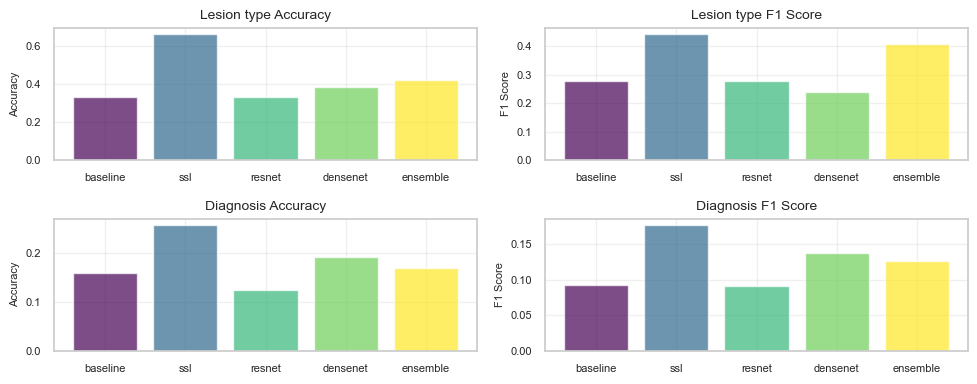

In [59]:
# Visualization of model comparison using utils
f, axes = plt.subplots(2, 2, figsize=(10, 4))

# Fine-grained accuracy comparison
models = ['baseline', 'ssl', 'resnet', 'densenet', 'ensemble']
fine_acc = comparison_df['Fine Balanced Acc'].tolist()
fine_f1 = comparison_df['Fine Macro F1'].tolist()
coarse_acc = comparison_df['Coarse Balanced Acc'].tolist()
coarse_f1 = comparison_df['Coarse Macro F1'].tolist()

colors = [MODELS_CONFIG.get(key, {}).get('color', '#666666') for key in all_results.keys()]

axes[1, 0].bar(models, fine_acc, color=colors, alpha=0.7)
axes[1, 0].set_title('Diagnosis Accuracy', fontsize = 10)
axes[1, 0].set_ylabel('Accuracy', fontsize = 8)
axes[1, 0].tick_params(axis='x', rotation=0)
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].bar(models, fine_f1, color=colors, alpha=0.7)
axes[1, 1].set_title('Diagnosis F1 Score', fontsize = 10)
axes[1, 1].set_ylabel('F1 Score', fontsize = 8)
axes[1, 1].tick_params(axis='x', rotation=0)
axes[1, 1].grid(True, alpha=0.3)

axes[0, 0].bar(models, coarse_acc, color=colors, alpha=0.7)
axes[0, 0].set_title('Lesion type Accuracy', fontsize = 10)
axes[0, 0].set_ylabel('Accuracy', fontsize = 8)
axes[0, 0].tick_params(axis='x', rotation=0)
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].bar(models, coarse_f1, color=colors, alpha=0.7)
axes[0, 1].set_title('Lesion type F1 Score', fontsize = 10)
axes[0, 1].set_ylabel('F1 Score', fontsize = 8)
axes[0, 1].tick_params(axis='x', rotation=0)
axes[0, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

f.savefig("../figures/model_comparison_brief.png", dpi=300, bbox_inches='tight')

### Compare all metrics

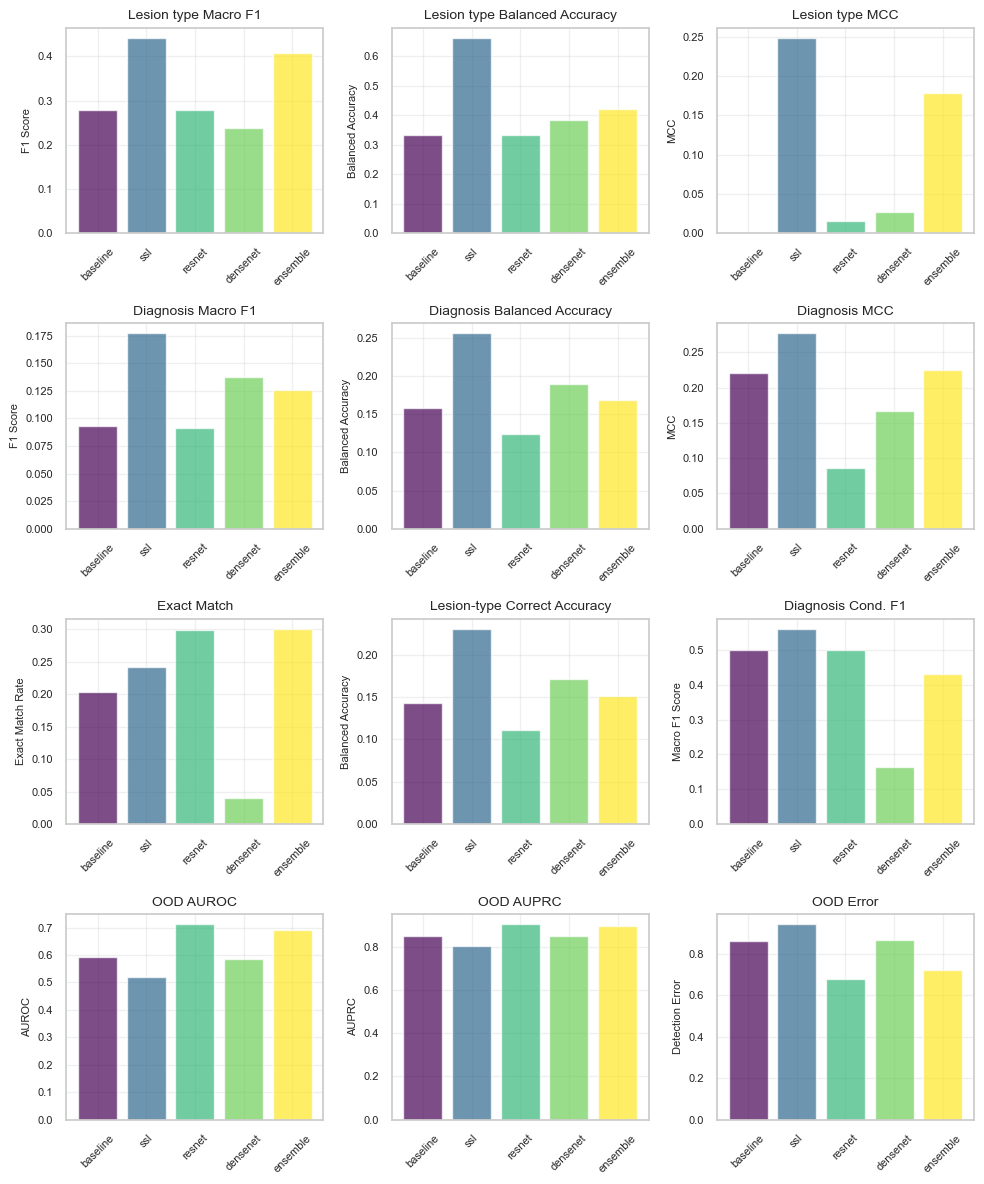

In [60]:
# Create comprehensive visualization
f, axes = plt.subplots(4, 3, figsize=(10, 12))

models = ['baseline', 'ssl', 'resnet', 'densenet', 'ensemble']
colors = [MODELS_CONFIG.get(key, {}).get('color', '#666666') for key in all_results.keys()]

## ---------------------------------------------------------------------------
axes[0, 0].bar(models, comparison_df['Coarse Macro F1'], color=colors, alpha=0.7)
axes[0, 0].set_title('Lesion type Macro F1', fontsize=10)
axes[0, 0].set_ylabel('F1 Score', fontsize=8)
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].bar(models, comparison_df['Coarse Balanced Acc'], color=colors, alpha=0.7)
axes[0, 1].set_title('Lesion type Balanced Accuracy', fontsize=10)
axes[0, 1].set_ylabel('Balanced Accuracy', fontsize=8)
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].grid(True, alpha=0.3)

axes[0, 2].bar(models, comparison_df['Coarse MCC'], color=colors, alpha=0.7)
axes[0, 2].set_title('Lesion type MCC', fontsize=10)
axes[0, 2].set_ylabel('MCC', fontsize=8)
axes[0, 2].tick_params(axis='x', rotation=45)
axes[0, 2].grid(True, alpha=0.3)

## ---------------------------------------------------------------------------
axes[1, 0].bar(models, comparison_df['Fine Macro F1'], color=colors, alpha=0.7)
axes[1, 0].set_title('Diagnosis Macro F1', fontsize=10)
axes[1, 0].set_ylabel('F1 Score', fontsize=8)
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].bar(models, comparison_df['Fine Balanced Acc'], color=colors, alpha=0.7)
axes[1, 1].set_title('Diagnosis Balanced Accuracy', fontsize=10)
axes[1, 1].set_ylabel('Balanced Accuracy', fontsize=8)
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].grid(True, alpha=0.3)

axes[1, 2].bar(models, comparison_df['Fine MCC'], color=colors, alpha=0.7)
axes[1, 2].set_title('Diagnosis MCC', fontsize=10)
axes[1, 2].set_ylabel('MCC', fontsize=8)
axes[1, 2].tick_params(axis='x', rotation=45)
axes[1, 2].grid(True, alpha=0.3)

## ---------------------------------------------------------------------------
axes[2, 0].bar(models, comparison_df['Exact Match'], color=colors, alpha=0.7)
axes[2, 0].set_title('Exact Match', fontsize=10)
axes[2, 0].set_ylabel('Exact Match Rate', fontsize=8)
axes[2, 0].tick_params(axis='x', rotation=45)
axes[2, 0].grid(True, alpha=0.3)

axes[2, 1].bar(models, comparison_df['Coarse Correct'], color=colors, alpha=0.7)
axes[2, 1].set_title('Lesion-type Correct Accuracy', fontsize=10)
axes[2, 1].set_ylabel('Balanced Accuracy', fontsize=8)
axes[2, 1].tick_params(axis='x', rotation=45)
axes[2, 1].grid(True, alpha=0.3)

axes[2, 2].bar(models, comparison_df['Fine Conditional'], color=colors, alpha=0.7)
axes[2, 2].set_title('Diagnosis Cond. F1', fontsize=10)
axes[2, 2].set_ylabel('Macro F1 Score', fontsize=8)
axes[2, 2].tick_params(axis='x', rotation=45)
axes[2, 2].grid(True, alpha=0.3)

## ---------------------------------------------------------------------------
axes[3, 0].bar(models, comparison_df['OOD AUROC'], color=colors, alpha=0.7)
axes[3, 0].set_title('OOD AUROC', fontsize=10)
axes[3, 0].set_ylabel('AUROC', fontsize=8)
axes[3, 0].tick_params(axis='x', rotation=45)
axes[3, 0].grid(True, alpha=0.3)

axes[3, 1].bar(models, comparison_df['OOD AUPRC'], color=colors, alpha=0.7)
axes[3, 1].set_title('OOD AUPRC', fontsize=10)
axes[3, 1].set_ylabel('AUPRC', fontsize=8)
axes[3, 1].tick_params(axis='x', rotation=45)
axes[3, 1].grid(True, alpha=0.3)

axes[3, 2].bar(models, comparison_df['OOD Detection Error'], color=colors, alpha=0.7)
axes[3, 2].set_title('OOD Error', fontsize=10)
axes[3, 2].set_ylabel('Detection Error', fontsize=8)
axes[3, 2].tick_params(axis='x', rotation=45)
axes[3, 2].grid(True, alpha=0.3)

for ax in axes.flat:
    ax.tick_params(axis='x', labelsize=8)
    ax.tick_params(axis='y', labelsize=8)
plt.tight_layout()
plt.show()

f.savefig("../figures/model_comparison.png", dpi=300, bbox_inches='tight')

### ID - OOD distributions

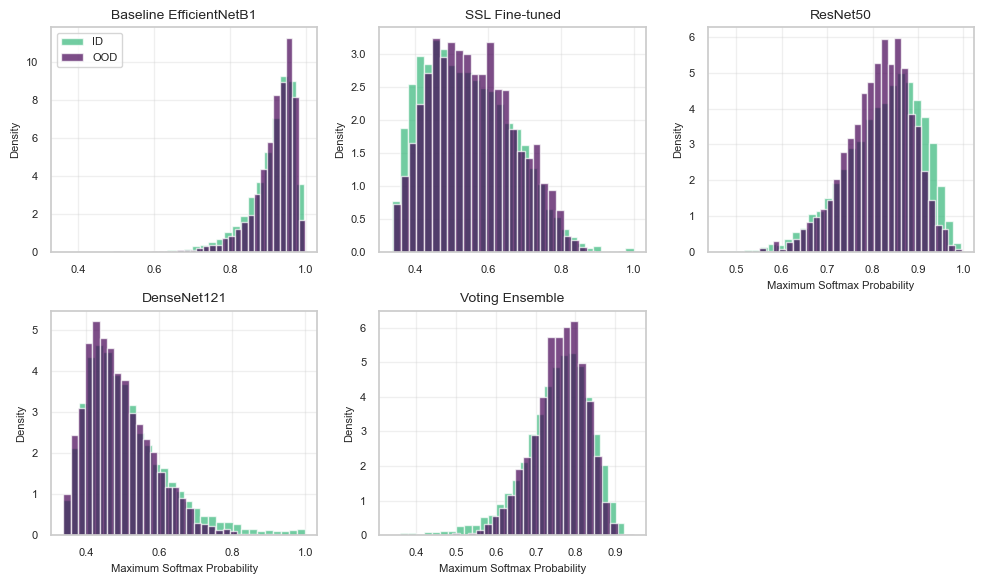

In [61]:
# Plot OOD detection comparison using utils
f = plt.figure(figsize=(10,6))

# Plot MSP distributions for each model
for i, (model_key, predictions) in enumerate(all_predictions.items()):

    if model_key == 'ensemble_weighted': continue
    model_name = MODELS_CONFIG[model_key]['name']
    
    id_msp_scores = utils.get_msp_scores(predictions['id_logits_h1'])
    ood_msp_scores = utils.get_msp_scores(predictions['ood_logits_h1'])
    
    plt.subplot(2, 3, i+1)
    # Use consistent viridis colors: ID = green-blue, OOD = dark purple
    plt.hist(id_msp_scores, bins=30, alpha=0.7, label='ID', color='#35b779', density=True)
    plt.hist(ood_msp_scores, bins=30, alpha=0.7, label='OOD', color='#440154', density=True)
    plt.title(f'{model_name}', fontsize=10)
    if i>=2: plt.xlabel('Maximum Softmax Probability')
    plt.ylabel('Density')
    if i == 0: plt.legend()
    plt.grid(True, alpha=0.3)

fig = plt.gcf()
for ax in fig.axes:
    # x/y label font sizes
    ax.xaxis.label.set_size(8)
    ax.yaxis.label.set_size(8)
    # tick label font sizes
    ax.tick_params(axis="both", which="both", labelsize=8)
    # legend font size (if present)
    leg = ax.get_legend()
    if leg:
        for t in leg.get_texts():
            t.set_fontsize(8)

plt.tight_layout()
plt.show()

f.savefig("../figures/ood_separation.png", dpi=300, bbox_inches='tight')